<a href="https://colab.research.google.com/github/Nish077/Indian_sign_language_CNN/blob/main/ISL_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kaustubhjdaware","key":"294cc38b7430690b9385ba3059ba90fb"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d prathumarikeri/indian-sign-language-isl
!unzip -o indian-sign-language-isl.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Indian/V/819.jpg  
  inflating: /content/dataset/Indian/V/82.jpg  
  inflating: /content/dataset/Indian/V/820.jpg  
  inflating: /content/dataset/Indian/V/821.jpg  
  inflating: /content/dataset/Indian/V/822.jpg  
  inflating: /content/dataset/Indian/V/823.jpg  
  inflating: /content/dataset/Indian/V/824.jpg  
  inflating: /content/dataset/Indian/V/825.jpg  
  inflating: /content/dataset/Indian/V/826.jpg  
  inflating: /content/dataset/Indian/V/827.jpg  
  inflating: /content/dataset/Indian/V/828.jpg  
  inflating: /content/dataset/Indian/V/829.jpg  
  inflating: /content/dataset/Indian/V/83.jpg  
  inflating: /content/dataset/Indian/V/830.jpg  
  inflating: /content/dataset/Indian/V/831.jpg  
  inflating: /content/dataset/Indian/V/832.jpg  
  inflating: /content/dataset/Indian/V/833.jpg  
  inflating: /content/dataset/Indian/V/834.jpg  
  inflating: /content/dataset/Indian/V/835.jpg  
  inflating: /conten

In [ ]:
df = '/content/dataset/Indian'
print("Classes:", os.listdir(df))  # List folder names (class names)


Classes: ['J', 'N', 'E', '6', 'D', 'L', 'U', 'F', 'M', '8', 'O', 'A', '3', '4', 'G', '5', 'Y', 'Q', 'I', 'S', '7', '2', 'T', 'C', 'Z', 'W', 'P', '9', 'V', 'H', 'R', 'X', '1', 'K', 'B']


In [ ]:
#for 224
# mean: tensor([0.1889, 0.1464, 0.1580])
# std: tensor([0.2239, 0.1588, 0.1144])

# Dataset-specific normalization values
mean = torch.tensor([0.1886, 0.1462, 0.1578])
std = torch.tensor([0.2258, 0.1611, 0.1172])


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


In [ ]:
# Load dataset
df = datasets.ImageFolder(root='/content/dataset/Indian', transform=transform)
print(len(df.classes))

35


In [ ]:
# Split sizes
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
test_size = len(df) - train_size - val_size
batch_size = 64


In [ ]:
# Split dataset
train_dataset, val_dataset, test_dataset = random_split(df, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
num_classes = len(df.classes)

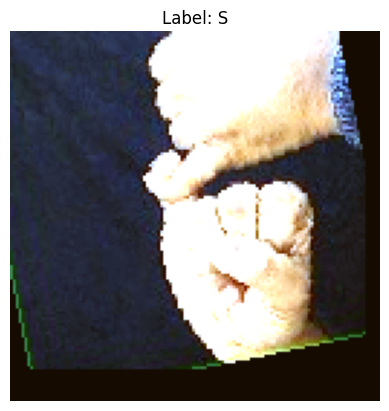

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for images, labels in train_loader:
    break  # Exit the loop after the first batch is loaded

# Select the first image from the batch
img = images[0]
label = labels[0]

# Convert the image to a NumPy array and denormalize it
img = img.numpy().transpose((1, 2, 0))
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
img = std * img + mean
img = np.clip(img, 0, 1)

# Display the image
plt.imshow(img)
plt.title(f"Label: {df.classes[label]}")
plt.axis('off')
plt.show()

In [ ]:
#Model definition
class SignLanguageCNN(nn.Module):
   def __init__(self, num_classes):
      super(SignLanguageCNN, self).__init__()
      # Define layers

      self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU()
      )
      self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU()
      )
      self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU()
      )
      self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU()
      )
      self.pool = nn.MaxPool2d(2, 2)  # MaxPooling 2x2
      self.dropout = nn.Dropout(0.5)
      self.flatten = nn.Flatten()

      self.fc1 = nn.Linear(128 * 8 * 8, 256)  # Adjusted for 128x128 input size
      self.fc2 = nn.Linear(256, num_classes)

   def forward(self, x):
      x = self.pool(self.conv1(x))
      x = self.pool(self.conv2(x))
      x = self.pool(self.conv3(x))
      x = self.pool(self.conv4(x))

      x = self.flatten(x)

      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = self.fc2(x)
      return x

In [ ]:
# Model instantiation
model = SignLanguageCNN(num_classes=num_classes).to(device)


In [ ]:

# Save checkpoint
checkpoint_path = "sign_language_model.pth"

def save_checkpoint(epoch, model, optimizer, scheduler, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at epoch {epoch}.")


In [ ]:

# Load checkpoint
def load_checkpoint(path, model, optimizer, scheduler):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}.")
    return start_epoch


In [ ]:

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=1e-6)


In [ ]:
# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [ ]:

# Resume training if checkpoint exists
if os.path.exists(checkpoint_path):
    start_epoch = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
else:
    start_epoch = 0


# Training
epochs = 40
patience = 5
early_stopping = EarlyStopping(patience=patience)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(start_epoch, epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.2f}%  - Train Accuracy: {train_accuracy:.2f}%")

    scheduler.step(val_loss)
    save_checkpoint(epoch + 1, model, optimizer, scheduler, checkpoint_path)

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break


Epoch 1/40 - Train Loss: 0.6305 - Val Loss: 0.0395 - Val Accuracy: 98.46%  - Train Accuracy: 80.97%
Checkpoint saved at epoch 1.
Epoch 2/40 - Train Loss: 0.1247 - Val Loss: 0.0362 - Val Accuracy: 98.62%  - Train Accuracy: 95.56%
Checkpoint saved at epoch 2.
Epoch 3/40 - Train Loss: 0.1048 - Val Loss: 0.0052 - Val Accuracy: 99.79%  - Train Accuracy: 96.23%
Checkpoint saved at epoch 3.
Epoch 4/40 - Train Loss: 0.0890 - Val Loss: 0.0115 - Val Accuracy: 99.63%  - Train Accuracy: 96.77%
Checkpoint saved at epoch 4.
Epoch 5/40 - Train Loss: 0.0786 - Val Loss: 0.0321 - Val Accuracy: 98.95%  - Train Accuracy: 97.10%
Checkpoint saved at epoch 5.
Epoch 6/40 - Train Loss: 0.0664 - Val Loss: 0.0026 - Val Accuracy: 99.91%  - Train Accuracy: 97.63%
Checkpoint saved at epoch 6.
Epoch 7/40 - Train Loss: 0.0688 - Val Loss: 0.0035 - Val Accuracy: 99.91%  - Train Accuracy: 97.58%
Checkpoint saved at epoch 7.
Epoch 8/40 - Train Loss: 0.0591 - Val Loss: 0.0084 - Val Accuracy: 99.81%  - Train Accuracy: 97.8

In [ ]:
#  Save the model for inference
torch.save(model.state_dict(), 'sign_language_model_inference.pth')
print("Model saved for inference.")


Model saved for inference.


In [ ]:
# Testing phase
model.eval()
test_loss, correct, total = 0.0, 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.0000, Test Accuracy: 100.00%


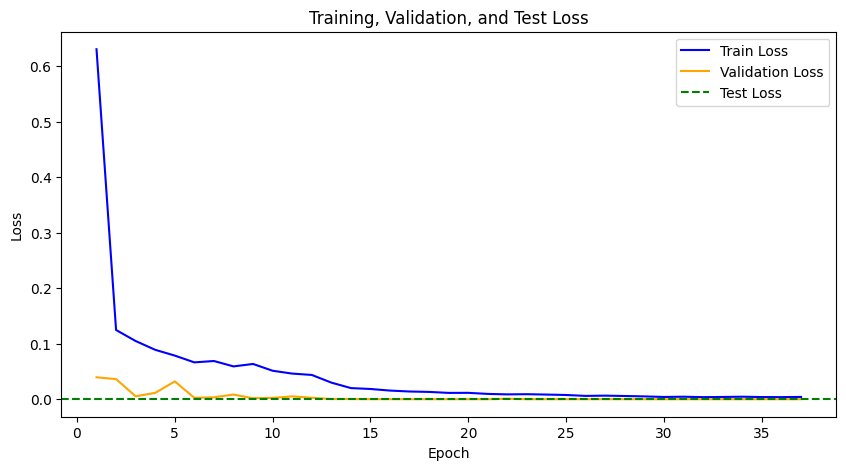

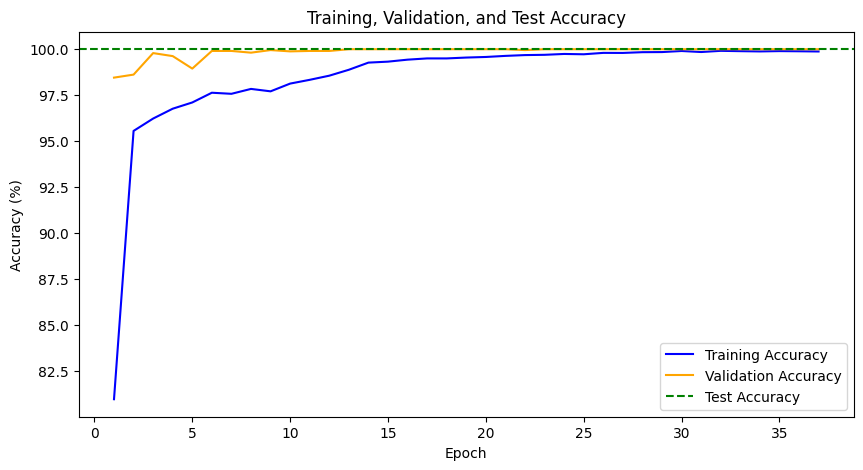

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       119
           2       1.00      1.00      1.00       111
           3       1.00      1.00      1.00       129
           4       1.00      1.00      1.00       103
           5       1.00      1.00      1.00       125
           6       1.00      1.00      1.00       125
           7       1.00      1.00      1.00       110
           8       1.00      1.00      1.00       121
           9       1.00      1.00      1.00       110
           A       1.00      1.00      1.00       122
           B       1.00      1.00      1.00       120
           C       1.00      1.00      1.00       148
           D       1.00      1.00      1.00       128
           E       1.00      1.00      1.00       125
           F       1.00      1.00      1.00       135
           G       1.00      1.00      1.00       111
           H       1.00      1.00      1.00       119
           I       1.00    

In [ ]:
# Plot training, validation, and test loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
plt.axhline(y=test_loss, color='green', linestyle='--', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()

# Plot training, validation, and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.axhline(y=test_accuracy, color='green', linestyle='--', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=df.classes))
